In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

print("Path to dataset files:", path)

c:\Users\Юзер\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Юзер\.cache\kagglehub\datasets\usdot\flight-delays\versions\1


In [1]:
import matplotlib.pyplot as plt
import pandas as pd


df_flights = pd.read_csv("flights.csv", low_memory=False)
df_airports = pd.read_csv("airports.csv", low_memory=False)
df_airlines = pd.read_csv("airlines.csv", low_memory=False)

#Добавляем месяц для анализа(это для одной из задач)
df_flights['MONTH'] = df_flights['MONTH'].map({
    1: 'Янв',
    2: 'Фев',
    3: 'Март',
    4: 'Апр',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Авг',
    9: 'Сент',
    10: 'Окт',
    11: 'Нояб',
    12: 'Дек'
})


In [7]:
df_flights = df_flights[df_flights['DEPARTURE_DELAY']>= 0]

df_flights = df_flights.dropna(subset=['DEPARTURE_DELAY'])
df_flights = df_flights.dropna(subset=['DEPARTURE_TIME'])
df_flights = df_flights.loc[(df_flights.ORIGIN_AIRPORT.apply(len) == 3)]

In [4]:
from matplotlib import pyplot
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [5]:
inverse_plot_colorscheme()

In [8]:
df_flights.head()
#df_airlines.head()
#df_airports.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
7,2015,Янв,1,4,US,2013,N584UW,LAX,CLT,30,...,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,Янв,1,4,DL,1173,N826DN,LAS,ATL,30,...,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
12,2015,Янв,1,4,DL,1434,N547US,LAX,MSP,35,...,605.0,-4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20,2015,Янв,1,4,NK,520,N525NK,LAS,MCI,55,...,543.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
27,2015,Янв,1,4,NK,597,N528NK,MSP,FLL,115,...,607.0,25.0,0,0,NaN,25.0,0.0,0.0,0.0,0.0


посмотрим на отмены рейсов по компаниям

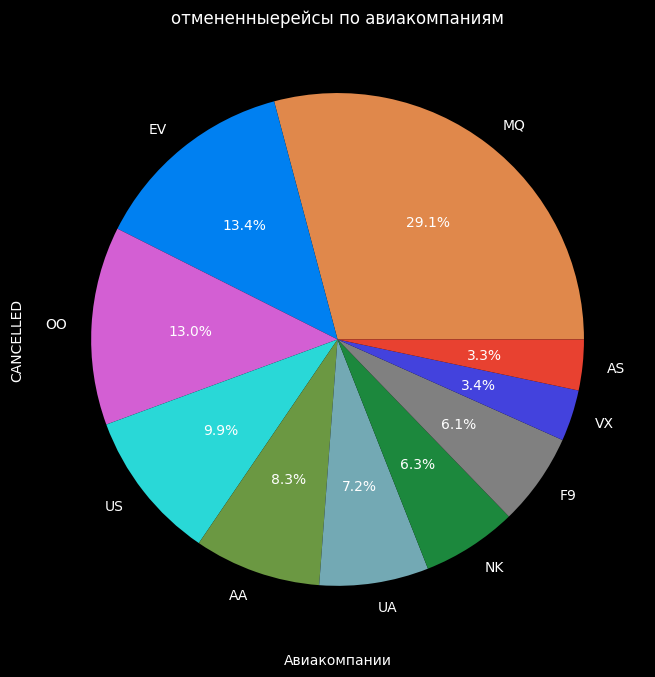

In [9]:
#Рассчитываем процент отмененных рейсов по авиакомпаниям
func = df_flights.groupby('AIRLINE')['CANCELLED'].mean().sort_values(ascending=False).head(10)

#Картиночка
plt.figure(figsize=(12, 6))
func.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('отмененныерейсы по авиакомпаниям')
plt.xlabel("Авиакомпании")
plt.show()


авиакомпания MQ отменяет рейсы чаще всех, поэтому там нужно посмотреть на планирование/ресурсы компании

посмотрим на задержку по времени суток

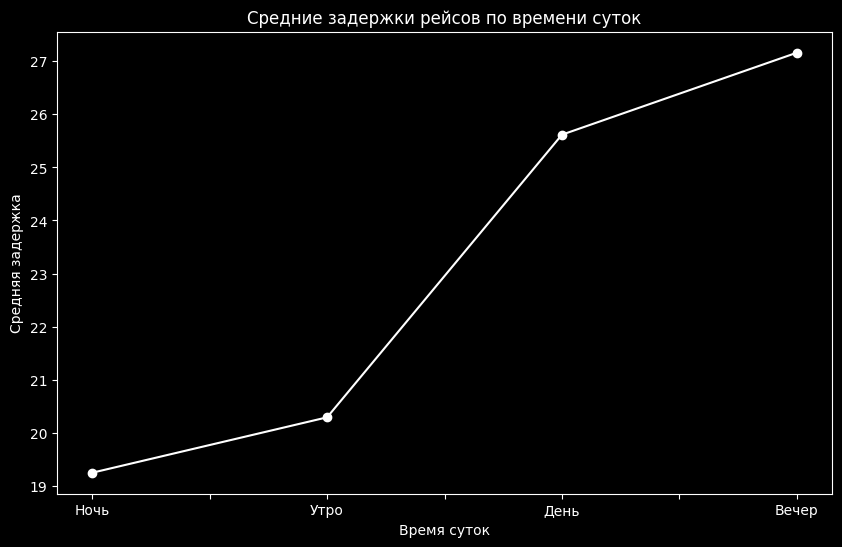

In [11]:
#Добавляем колонку для времени суток
df_flights['DEPARTURE_HOUR'] = df_flights['SCHEDULED_DEPARTURE'] // 100  #получаем час из времени в формате HHMM
df_flights['TIME_OF_DAY'] = pd.cut(df_flights['DEPARTURE_HOUR'], bins=[0, 6, 12, 18, 24], labels=["Ночь", "Утро", "День", "Вечер"])

#Рассчитываем среднюю задержку по времени суток
func = df_flights.groupby('TIME_OF_DAY', observed=True)['ARRIVAL_DELAY'].mean()

plt.figure(figsize=(10, 6))
func.plot(kind='line', color='white', marker='o')
plt.title("Средние задержки рейсов по времени суток")
plt.xlabel("Время суток")
plt.ylabel("Средняя задержка")
plt.show()


вечером задержки в среднем больше, возможно из-за того, что люди после работы куда-то хотят лететь

потребуется перераспределение ресурсов, чтобы вечером было больше возможностей улететь

посмотрм на среднуюю задержку в разных авиакомпаниях

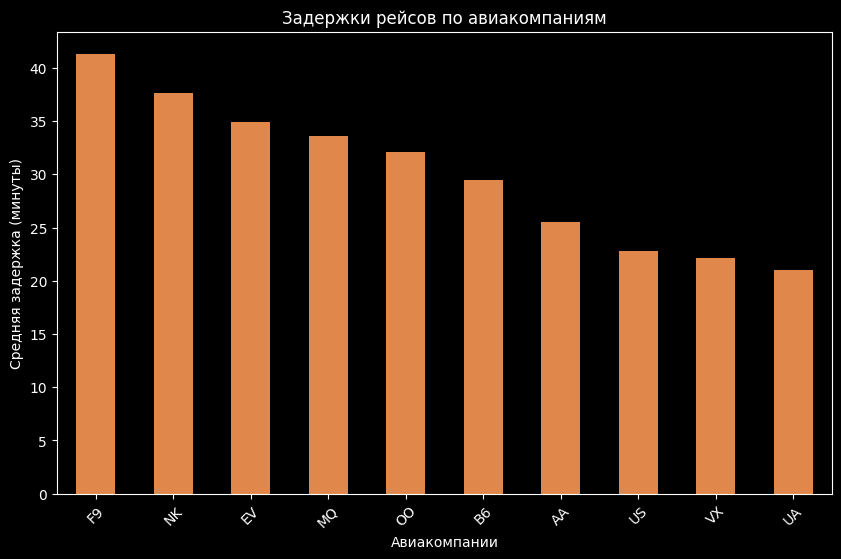

In [12]:
#Группируем по авиакомпании и рассчитываем среднюю задержку
func = df_flights.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values(ascending=False).head(10)


plt.figure(figsize=(10, 6))
func.plot(kind='bar')
plt.title("Задержки рейсов по авиакомпаниям")
plt.xlabel("Авиакомпании")
plt.ylabel("Средняя задержка (минуты)")
plt.xticks(rotation=45)
plt.show()


компании NK и F9 явно выбиваются из общего списка, возможно, недоразвиты мощности аэропортов или плохое планирование

еще посмотрим на среднемесячную задержку

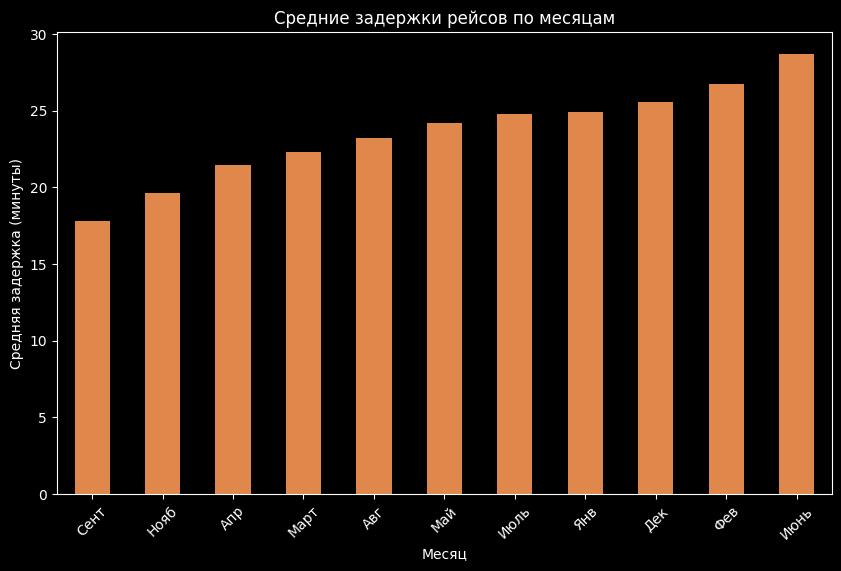

In [13]:

#Рассчитываем средние задержки по месяцам
func = df_flights.groupby('MONTH')['ARRIVAL_DELAY'].mean().sort_values()

#Картиночка
plt.figure(figsize=(10, 6))
func.plot(kind='bar')
plt.title("Средние задержки рейсов по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Средняя задержка (минуты)")
plt.xticks(rotation=45)
plt.show()


все летят в отпуск и домой после тяжелого семестра, тоже нужно перераспределение ресурсов

посмотрим на перенаправление в другие аэропорты

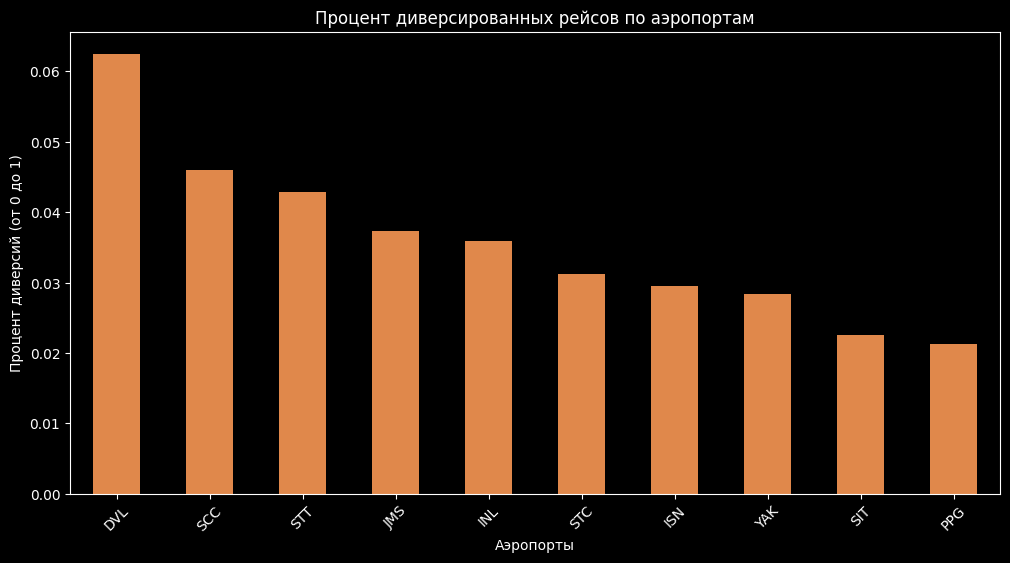

In [14]:
#Рассчитываем процент диверсий рейсов по аэропортам
func = df_flights.groupby('ORIGIN_AIRPORT')['DIVERTED'].mean().sort_values(ascending=False).head(10)


plt.figure(figsize=(12, 6))
func.plot(kind='bar')
plt.title("Процент диверсированных рейсов по аэропортам")
plt.xlabel("Аэропорты")
plt.ylabel("Процент диверсий (от 0 до 1)")
plt.xticks(rotation=45)
plt.show()

аэропорт 13970 ивыбивается относительно остальных, наверное, большая нагрузка и/или нехватка ресурсов, поэтому его нужно модернизировать и более грамотно планировать рейсы